In [1]:
from __future__ import print_function
import time
import os
import sys
sys.path.append('/home/rbabu/.local/lib/python3.7/site-packages/')
sys.path.append('/home/rbabu/.local/lib/python3.7/site-packages/histlite/')
sys.path.append('/home/rbabu/csky/')
import matplotlib
from matplotlib import rc
matplotlib.use('Agg')
import histlite as hl
from matplotlib import pyplot as plt
from csky.ipyconfig import *
from csky import bk, analysis, coord, dists, hyp, inj, llh, pdf, selections, trial, utils
import csky as cy
import healpy as hp
    import numpy as np
%matplotlib inline
rc('text',usetex=False)
cy.plotting.mrichman_mpl(tex=False)

mp_cpus = 1
base_dir = ''  #SET THIS BASE DIR
plot_dir = cy.utils.ensure_dir('/home/rbabu/nu_sources/2024_4FGL_PlaneSurvey'.format(base_dir))
ana_dir = cy.utils.ensure_dir('/home/rbabu/nu_sources/2024_4FGL_PlaneSurvey/cache')

In [2]:
repo = cy.selections.Repository()
psspec = cy.selections.PSDataSpecs.IC86v4
cspec = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

Analysis Repo for masking plane

In [3]:
ana = cy.get_analysis(cy.selections.repo, 'version-004-p02', cy.selections.PSDataSpecs.IC86v4,'version-001-p01', cy.selections.DNNCascadeDataSpecs.DNNC_10yr,mask_plane=True)
ana_dir = cy.utils.ensure_dir('/home/rbabu/4fgl-ana/cache')
ana.save(ana_dir)
cy.CONF['ana'] = ana
cy.CONF['mp_cpus'] = 20
print(cy.CONF)

Setting up Analysis for:
IC86v4, DNNCascade_10yr
Setting up IC86v4...
Reading /data/ana/analyses/ps_tracks/version-004-p02/IC86_2016_MC.npy ...
Reading /data/ana/analyses/ps_tracks/version-004-p02/IC86_2011_exp.npy ...
Reading /data/ana/analyses/ps_tracks/version-004-p02/IC86_2012_exp.npy ...
Reading /data/ana/analyses/ps_tracks/version-004-p02/IC86_2013_exp.npy ...
Reading /data/ana/analyses/ps_tracks/version-004-p02/IC86_2014_exp.npy ...
Reading /data/ana/analyses/ps_tracks/version-004-p02/IC86_2015_exp.npy ...
Reading /data/ana/analyses/ps_tracks/version-004-p02/IC86_2016_exp.npy ...
Reading /data/ana/analyses/ps_tracks/version-004-p02/IC86_2017_exp.npy ...
Reading /data/ana/analyses/ps_tracks/version-004-p02/IC86_2018_exp.npy ...
Reading /data/ana/analyses/ps_tracks/version-004-p02/IC86_2019_exp.npy ...
Reading /data/ana/analyses/ps_tracks/version-004-p02/IC86_2020_exp.npy ...
Reading /data/ana/analyses/ps_tracks/version-004-p02/IC86_2021_exp.npy ...
Reading /data/ana/analyses/ps_t

In [37]:
from pandas import *
fermi_srcname=[]
fermi_srcl=[]
fermi_srcb=[]
excl1_srcname=[]
excl1_srcl=[]
excl1_srcb=[]
excl2_srcname=[]
excl2_srcl=[]
excl2_srcb=[]

fermi_table=read_csv("source_list/fermidata.csv")
excl1_table=read_csv("source_list/icecube2023data.csv")
excl2_table=read_csv("source_list/icecubewikidata.csv")

fermi_srcname=fermi_table['4FGLName'].tolist()
fermi_srcl=fermi_table['glon'].tolist()
fermi_srcb=fermi_table['glat'].tolist()
excl1_srcname=excl1_table['Name'].tolist()
excl1_srcl=excl1_table['ra'].tolist()
excl1_srcb=excl1_table['dec'].tolist()
excl2_srcname=excl2_table['Name'].tolist()
excl2_srcl=excl2_table['ra'].tolist()
excl2_srcb=excl2_table['dec'].tolist()

print(len(fermi_srcl), len(excl1_srcl), len(excl2_srcl))


54 36 38


In [38]:
import histlite.heal as heal
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import Angle
import math
for i in range(len(excl1_srcname)):
    c_icrs = SkyCoord(excl1_srcl[i], excl1_srcb[i], unit=u.deg, frame='icrs')
    c_gal=c_icrs.galactic
    l_rad = c_gal.l
    b_rad = c_gal.b
    excl1_srcl[i] = l_rad
    excl1_srcb[i] = b_rad

for i in range(len(excl2_srcname)):
    c_icrs = SkyCoord(excl2_srcl[i], excl2_srcb[i], unit=u.deg, frame='icrs')
    c_gal=c_icrs.galactic
    l_rad = c_gal.l
    b_rad = c_gal.b
    excl2_srcl[i] = l_rad
    excl2_srcb[i] = b_rad


In [39]:
import healpy
def thetaphi_to_mpl(theta, phi):
    theta, phi = np.atleast_1d(theta), np.atleast_1d(phi)
    x = np.pi - phi
    x[x > np.pi] -= 2*np.pi
    y = np.pi/2 - theta
    return x, y
def plot_gc(self, ax, color='.5', s=15, **kw):
    l = 0
    theta_b = np.pi/2
    if self.coord == 'C':
        r = healpy.Rotator(coord='GC')
        theta, phi = r(theta_b, l)
    elif self.coord == 'G':
        theta, phi = theta_b, l
    else:
        raise ValueError('bad coord {}'.format(self.coord))
    x, y = self.thetaphi_to_mpl(theta, phi)
    ax.scatter(x, y, color=color, s=s, **kw)

[-1.50805167] [-0.50503148]
266d24m17.95783156s -28d56m10.23994245s
-1.508051535747339 -0.5050315748856246


<Figure size 768x576 with 0 Axes>

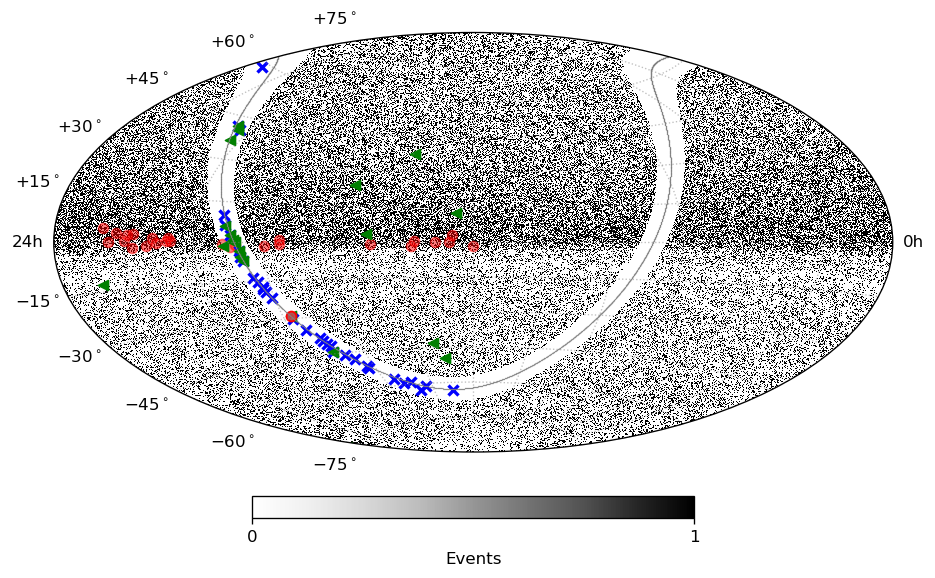

In [40]:
plt.clf()
a = ana['IC86v4']
bg_data, data = a.bg_data, a.data
bg_map = heal.hist(512, bg_data.dec, bg_data.ra)

#fig, ax = plt.subplots (subplot_kw=dict (projection='aitoff'))
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1, projection='aitoff')
sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap='Greys', vmin=0,vmax=1))
mesh, cb = sp.plot_map(ax, bg_map.map, n_ticks=2)
for i in range(len(fermi_srcname)):
    cc_gal = SkyCoord(fermi_srcl[i], fermi_srcb[i], unit=u.deg, frame='galactic')
    cc_icrs=cc_gal.icrs
    ll_rad = cc_icrs.ra.radian
    ll_rad =-(np.pi + cc_icrs.ra.wrap_at(180 * u.deg).radian)
    bb_rad = cc_icrs.dec.radian
    cc = ax.scatter(ll_rad, bb_rad, color='red', marker='o', alpha=0.5)

for i in range(len(excl1_srcname)):
    c_gal = SkyCoord(excl1_srcl[i], excl1_srcb[i], unit=u.deg, frame='galactic')
    c_icrs=c_gal.icrs
    l_rad = c_icrs.ra.radian
    l_rad =-(np.pi + c_icrs.ra.wrap_at(180 * u.deg).radian)
    b_rad = c_icrs.dec.radian
    c = ax.scatter(l_rad, b_rad, color='blue', marker='x')

for i in range(len(excl2_srcname)):
    c_gal = SkyCoord(excl2_srcl[i], excl2_srcb[i], unit=u.deg, frame='galactic')
    c_icrs=c_gal.icrs
    l_rad = c_icrs.ra.radian
    l_rad =-(np.pi + c_icrs.ra.wrap_at(180 * u.deg).radian)
    b_rad = c_icrs.dec.radian
    c = ax.scatter(l_rad, b_rad, color='green', marker='<')


l = 0
theta_b = np.pi/2
theta, phi = theta_b, l
r = healpy.Rotator(coord='GC')
theta, phi = r(theta_b, l)
x, y = thetaphi_to_mpl(theta, phi)
print(x,y)
ax.scatter(x, y, color='red', s=15)


gc_cel = SkyCoord(0,0, unit=u.deg, frame='galactic')
gc_gal = gc_cel.icrs
print(gc_gal.ra, gc_gal.dec)
lc_rad = -(np.pi + gc_gal.ra.wrap_at(180 * u.deg).radian)
bc_rad =gc_gal.dec.radian
print(lc_rad, bc_rad)
c = ax.scatter(lc_rad, bc_rad, color='red')
kw = dict(color='.5', alpha=.5)
sp.plot_gp(ax, lw=0.5, **kw)
sp.plot_gc(ax, **kw)
cb.set_label ('Events')
ax.grid(**kw)
plt.tight_layout()
plt.savefig('plane-masked-allsources-final.png'.format(plot_dir),bbox_inches='tight')

In [ ]:
import histlite.heal as heal
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import Angle
import math
plt.clf()
a = ana['IC86v4']
bg_data, data = a.bg_data, a.data
bg_map = heal.hist(512, bg_data.dec, bg_data.ra)

#fig, ax = plt.subplots (subplot_kw=dict (projection='aitoff'))
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1, projection='aitoff')
sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap='Greys', vmin=0,vmax=1))
mesh, cb = sp.plot_map(ax, bg_map.map, n_ticks=2)
for i in range(len(fermi_srcname)):
    c_gal = SkyCoord(fermi_srcl[i], fermi_srcb[i], unit=u.deg, frame='galactic')
    c_icrs=c_gal.icrs
    l_rad = c_icrs.ra.radian
    l_rad =-(np.pi +c_icrs.ra.wrap_at(180 * u.deg).radian)
    b_rad = c_icrs.dec.radian
    #c = ax.scatter(l_rad, b_rad, color='red', marker='o', alpha=0.5)

for i in range(len(excl1_srcname)):
    c_gal = SkyCoord(excl1_srcl[i], excl1_srcb[i], unit=u.deg, frame='galactic')
    c_icrs=c_gal.icrs
    l_rad = c_icrs.ra.radian
    l_rad =-(np.pi +c_icrs.ra.wrap_at(180 * u.deg).radian)
    b_rad = c_icrs.dec.radian
    c = ax.scatter(l_rad, b_rad, color='blue', marker='x')

for i in range(len(excl2_srcname)):
    c_gal = SkyCoord(excl2_srcl[i], excl2_srcb[i], unit=u.deg, frame='galactic')
    c_icrs=c_gal.icrs
    l_rad = c_icrs.ra.radian
    l_rad =-(np.pi +c_icrs.ra.wrap_at(180 * u.deg).radian)
    b_rad = c_icrs.dec.radian
    #c = ax.scatter(l_rad, b_rad, color='green', marker='<')


l = 0
theta_b = np.pi/2
theta, phi = theta_b, l
r = healpy.Rotator(coord='GC')
theta, phi = r(theta_b, l)
x, y = thetaphi_to_mpl(theta, phi)
print(x,y)
ax.scatter(x, y, color='red', s=15)


gc_cel = SkyCoord(0,0, unit=u.deg, frame='galactic')
gc_gal = gc_cel.icrs
print(gc_gal.ra, gc_gal.dec)
lc_rad = -(np.pi + gc_gal.ra.wrap_at(180 * u.deg).radian)
bc_rad =gc_gal.dec.radian
print(lc_rad, bc_rad)
c = ax.scatter(lc_rad, bc_rad, color='red')
kw = dict(color='.5', alpha=.5)
sp.plot_gp(ax, lw=0.5, **kw)
sp.plot_gc(ax, **kw)
cb.set_label ('Events')
ax.grid(**kw)
plt.tight_layout()
plt.savefig('plane-masked-allsources.png'.format(plot_dir),bbox_inches='tight')